In [1]:
#!pip install tensorflow-gpu==1.13.1

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:150% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import model_to_dot
from IPython.display import SVG
from matplotlib import colors

import os, warnings
warnings.filterwarnings('ignore')

2023-12-01 23:43:15.290363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 23:43:15.290387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 23:43:15.290413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 23:43:15.298776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/is/.local/lib/python3.10/site-packages/scipy

In [4]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
CONDITIONAL_IMAGE_CHANNELS = 10
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
CONDITIONAL_IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CONDITIONAL_IMAGE_CHANNELS)
EPOCHS = 100

In [5]:
INPUT_FEATURES = ['elevation', 'wind_speed', 'wind_dir', 'tmin', 'tmax',
                  'landcover', 'precip', 'pdsi','solar', 'PrevFireMask']

In [6]:
man_length = 21550

MinMax = {'landcover':(10.0, 100.0),
              'tmax': (-41.95404185202824, 35.28747487720835),
              'tmin': (-42.4077221254351, 34.710974191122716),
              'wind_speed': (0.0002993076576944125, 14.27423496286687),
              'elevation': (-77.85292, 4379.4683),
              'wind_direction': (-179.99999083334689, 179.99999810000588),
              'solar_radiation': (-24.598765964771623, 964662.1183104622),
              'air_pressure': (99064.73425290409, 105551.80433948596),
              'precipitation': (-9.494998975299606e-05, 0.012117456275976952)}

In [7]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tensor, [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    #tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tensor, [64, 64])
    

    return combined_features, label


In [8]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [9]:
import tensorflow as tf
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
tfrecord_file = 'data2.tfrecords'

In [10]:
count_records(tfrecord_file)

2023-12-01 23:43:17.048576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 23:43:17.060828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 23:43:17.061082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

21550

In [11]:
dataset = tf.data.TFRecordDataset(tfrecord_file).cache()

dataset = dataset.map(_parse_function)

In [12]:
dataset = dataset.shuffle(buffer_size=man_length)
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Trainset analysis

inputs.shape: (64, 64, 64, 10)
labels.shape: (64, 64, 64)
len(TITLES): 11


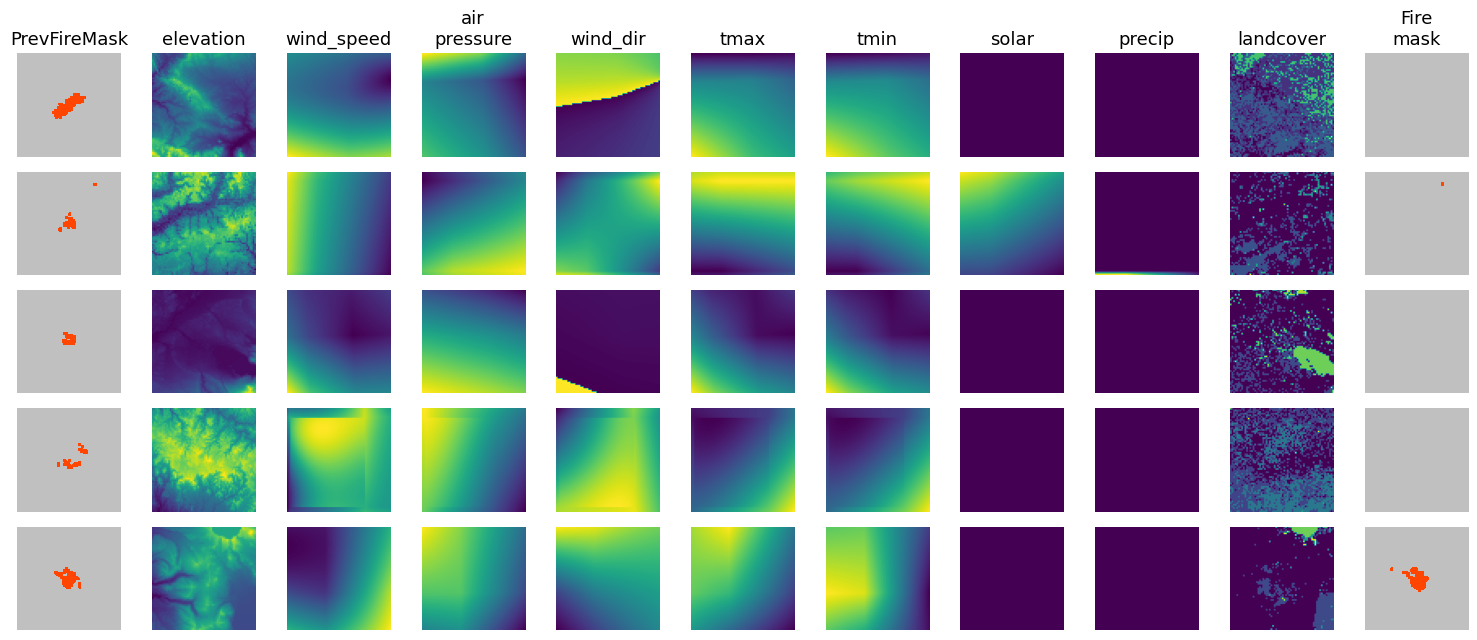

In [13]:
inputs, labels = next(iter(train_dataset))
print(f"inputs.shape: {inputs.shape}")
print(f"labels.shape: {labels.shape}")

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']
print(f"len(TITLES): {len(TITLES)}")


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

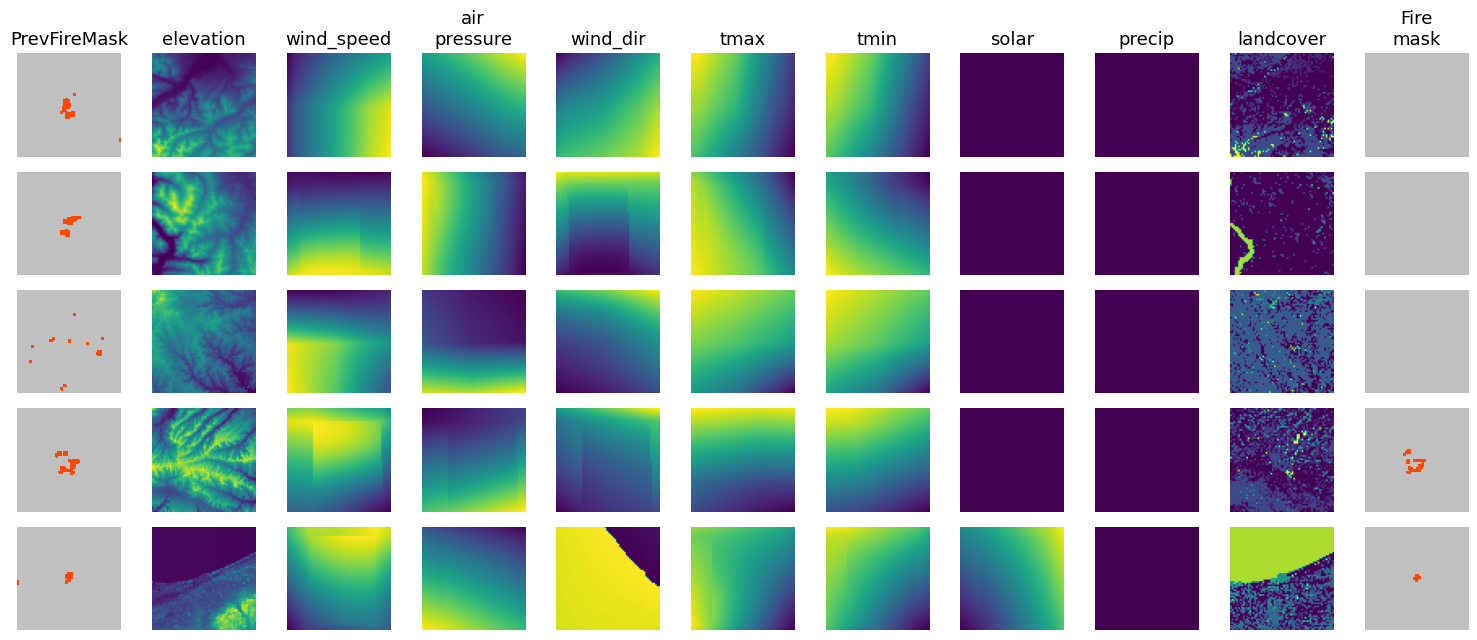

In [14]:
eval_dataset = eval_dataset.shuffle(1000)
inputs, labels = next(iter(eval_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

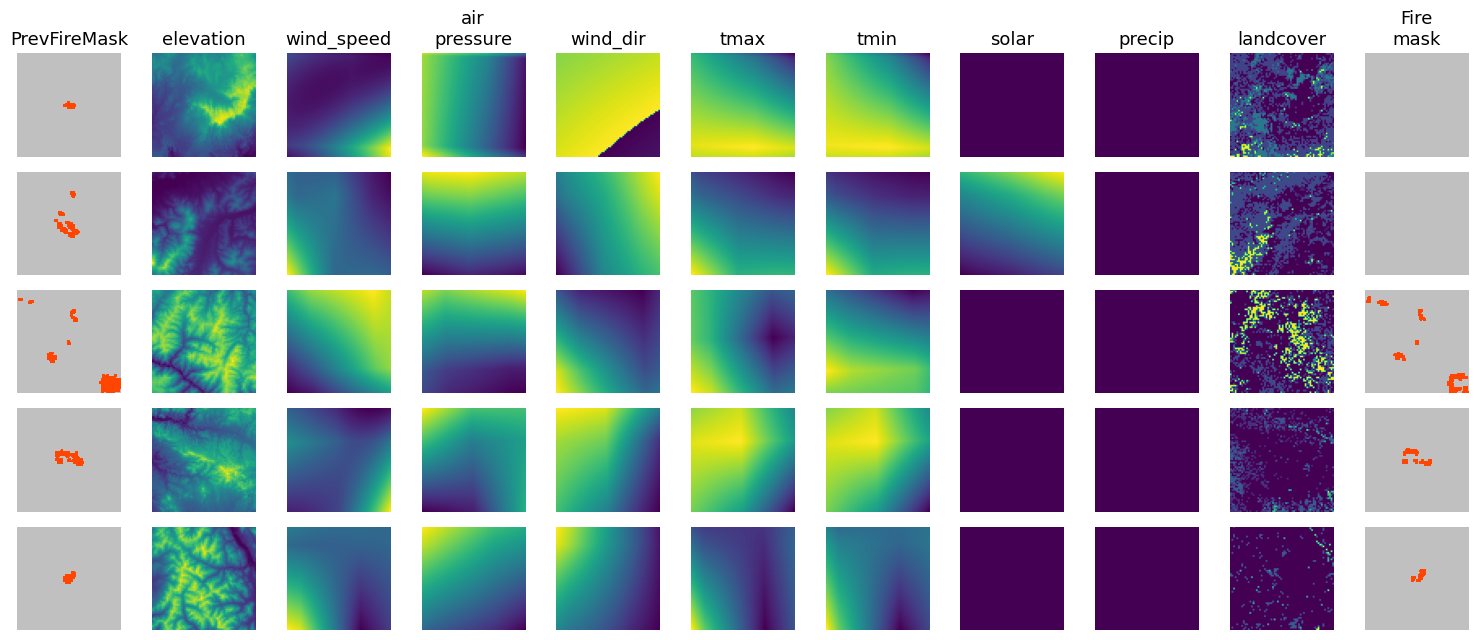

In [15]:
inputs, labels = next(iter(test_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Get all samples from TFRecords in arrays
first_it = True
cnt = 0
for x, y in test_dataset:
    cnt += 1
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
print(f"test inputs num batches = {cnt}")
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)
print(f"test_data_targets.shape {test_data_targets.shape}")
print(f"test_data_inputs.shape {test_data_inputs.shape}")

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, 0].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_true_flat = y_true.flatten()

test inputs num batches = 34
test_data_targets.shape (2155, 64, 64)
test_data_inputs.shape (2155, 64, 64, 10)


In [17]:
# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)

Accuracy: 0.983805
score_a (array([0.99660354, 0.14987446]), array([0.9870772 , 0.40378402]), array([0.99181749, 0.21860737]), array([8777356,   49524]))
precision 0.9838045832729119
Recall: 0.983805
F1 score: 0.983805
[[8663928  113428]
 [  29527   19997]]


In [18]:
def build_generator(latent_dimension, conditional_image_shape):
    
    # Noise Input Layers
    noise_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(noise_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 16 * 16)(x)
    x = BatchNormalization()(x)
    noise_input = Reshape((16, 16, 128), input_shape = (128 * 16 * 16, ))(x)
    
    # # Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 7 * 7)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)

    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Combined Input
    combined_input = Concatenate()([noise_input, condition_input])
    
    # Generator Block 1
    x = UpSampling2D(size = (2, 2))(combined_input)
    x = Conv2D(64, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)
    
    # Generator Block 2
    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(1, (5, 5), padding = 'same')(x)
    output = Activation('tanh')(x)
    
    generator = Model([noise_input_placeholder, condition_input_placeholder], output, name = 'Generator')
    
    return generator

In [19]:
def build_discriminator(image_shape, conditional_image_shape, latent_dimension):
    
    # Image Input Layers
    image_input_placeholder = Input(image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(image_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(x)
    x = Activation('tanh')(x)
    image_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Previous Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 12 * 12)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((12, 12, 128), input_shape = (128 * 12 * 12, ))(x)
    
    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(x)
    x = Activation('tanh')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    combined_input = Concatenate()([image_input, condition_input])
    
    x = Flatten()(combined_input)
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    discriminator = Model([image_input_placeholder, condition_input_placeholder], output, name = 'Discriminator')
    
    return discriminator

In [20]:
def build_gan(generator, discriminator, image_shape, conditional_image_shape, latent_dimension):
    noise_input_placeholder = Input(shape = (latent_dimension, ), name = 'NoiseInput')
    condition_input_placeholder = Input(shape = (conditional_image_shape), name = 'ConditionInput')
    generated_image = generator([noise_input_placeholder, condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator([generated_image, condition_input_placeholder])
    gan = Model([noise_input_placeholder, condition_input_placeholder], validity)
    return gan

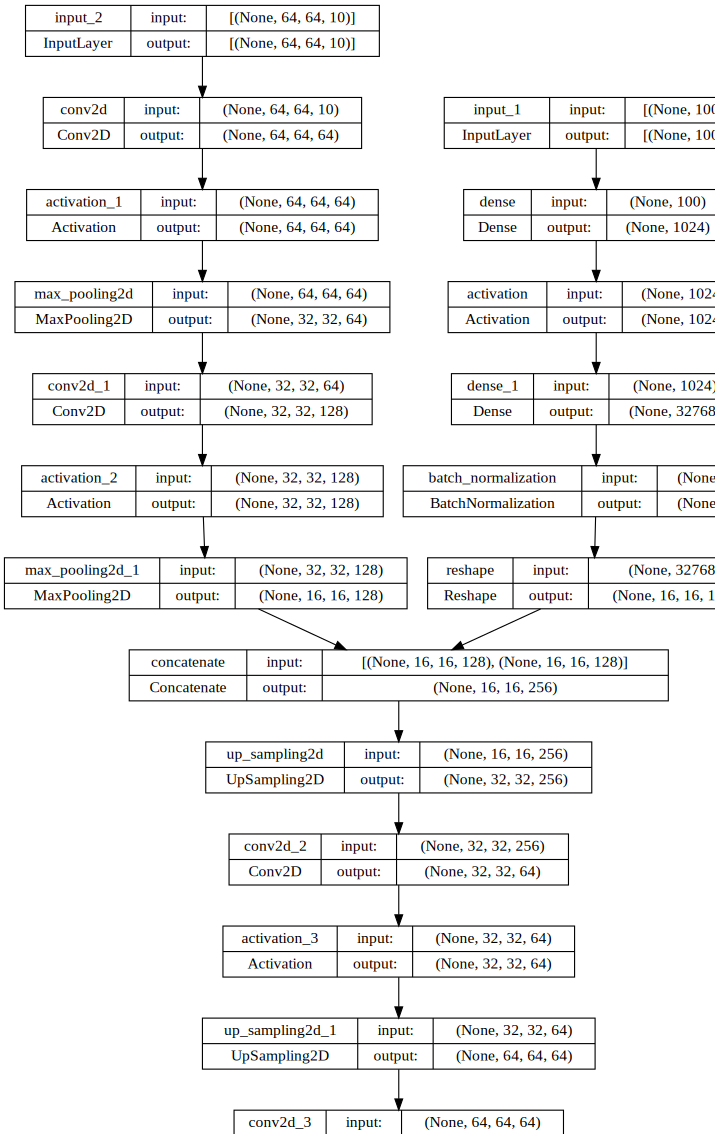

In [21]:
generator = build_generator(100, CONDITIONAL_IMAGE_SHAPE)
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True,dpi=65).create(prog = 'dot', format = 'svg'))

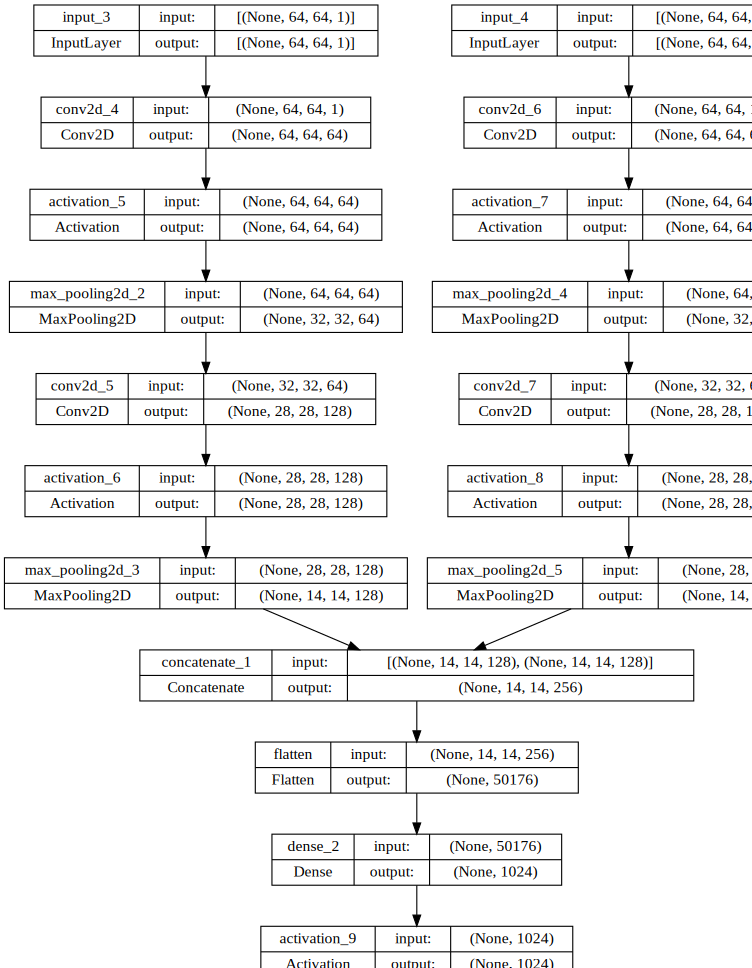

In [22]:
discriminator = build_discriminator((64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

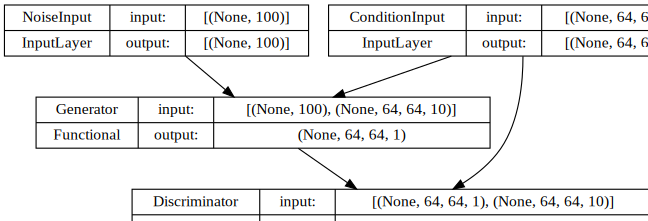

In [23]:
gan = build_gan(generator, discriminator, (64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

In [24]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

In [25]:
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [26]:
gpu_available = tf.test.is_gpu_available()
print(gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-12-01 23:43:47.608715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 23:43:47.608905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 23:43:47.609013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [27]:
from tqdm.notebook import tqdm


for epoch in range(EPOCHS):
    
    progress_bar = tqdm(desc = "Epoch: {0}".format(epoch), total = 21550)
    
    generator_loss_history, discriminator_loss_history = [], []
    
    for batch_labels, batch_images in train_dataset:
        #print(f"batch_labels.shape: {batch_labels.shape}")
        #print(f"batch_images.shape: {batch_images.shape}")
        #if batch_labels.shape[0] != BATCH_SIZE:
        #    continue
        cur_batch_size = batch_labels.shape[0] 
        
        noise = np.random.uniform(0, 1, size = (cur_batch_size, LATENT_DIMENSION))
        
        # Get a Batch from the dataset
        # batch_images = x_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        # batch_labels = y_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        
        # Fake Images
        generated_images = generator.predict([noise, batch_labels], verbose=None)
        batch_images = np.expand_dims(batch_images, axis=-1)
        
        # Batch Dataset
        x = np.concatenate((batch_images, generated_images))
        y = np.array([1] * cur_batch_size + [0] * cur_batch_size)
        discriminator_conditions = np.concatenate((batch_labels, batch_labels))
        
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch([x, discriminator_conditions], y)
        discriminator_loss_history.append(discriminator_loss)
        
        noise = np.random.uniform(0, 1, size = (cur_batch_size, LATENT_DIMENSION))
        
        # Training the Generator
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([noise, batch_labels], np.array([1] * cur_batch_size))
        generator_loss_history.append(generator_loss)
        discriminator.trainable = True
        
        progress_bar.update(cur_batch_size)
        progress_bar.set_description(f"generator_loss:{generator_loss:.5f} discriminator_loss: {discriminator_loss:.5f}")

Epoch: 0:   0%|          | 0/21550 [00:00<?, ?it/s]

2023-12-01 23:43:49.358853: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 23:43:49.364873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-01 23:43:49.454287: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch: 1:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 2:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 3:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 4:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 5:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 6:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 7:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 8:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 9:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 10:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 11:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 12:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 13:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 14:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 15:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 16:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 17:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 18:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 19:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 20:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 21:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 22:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 23:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 24:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 25:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 26:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 27:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 28:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 29:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 30:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 31:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 32:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 33:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 34:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 35:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 36:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 37:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 38:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 39:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 40:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 41:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 42:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 43:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 44:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 45:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 46:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 47:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 48:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 49:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 50:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 51:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 52:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 53:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 54:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 55:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 56:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 57:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 58:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 59:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 60:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 61:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 62:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 63:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 64:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 65:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 66:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 67:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 68:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 69:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 70:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 71:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 72:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 73:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 74:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 75:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 76:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 77:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 78:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 79:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 80:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 81:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 82:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 83:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 84:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 85:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 86:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 87:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 88:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 89:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 90:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 91:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 92:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 93:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 94:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 95:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 96:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 97:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 98:   0%|          | 0/21550 [00:00<?, ?it/s]

Epoch: 99:   0%|          | 0/21550 [00:00<?, ?it/s]

# Evaluation

In [28]:
model = generator

In [37]:
# Predict
y_pred=list()
for sample in tqdm(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    # print("\niter\n")
    #print(f"sample_exp.shape: {sample_exp.shape}")
    # #im = sample_exp[0, :, :, -1]
    # #print(f"im.shape: {im.shape}")
    # plt.imshow(sample_exp[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()

    noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
    #noise = np.zeros((1, LATENT_DIMENSION))
    
    pred = model.predict([noise, sample_exp], verbose = 0)
    
    # #print(f"pred.shape: {pred.shape}")
    # plt.imshow(pred[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

  0%|          | 0/2155 [00:00<?, ?it/s]

Accuracy: 0.990518
score_a (array([0.        , 0.9944926 , 0.03603493]), array([0.        , 0.99600643, 0.01782974]), array([0.        , 0.99524894, 0.02385584]), array([      0, 8777356,   49524]))
precision 0.990518280524942
Recall: 0.990518
F1 score: 0.990518
[[      0       0       0]
 [  11432 8742303   23621]
 [    227   48414     883]]


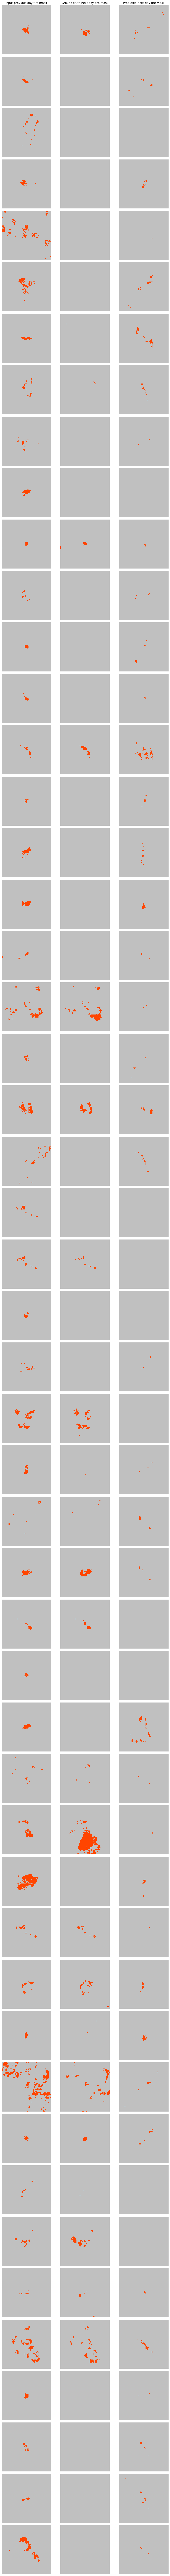

In [38]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [ ]:
# generator.save('./generator.h5')
# discriminator.save('./discriminator.h5')